<a href="https://colab.research.google.com/github/Gibsdevops/NLP_with_tensorflow/blob/main/nlp_lstms_with_reviews_subwords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import pandas as pd
import numpy as np

In [3]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P -O /tmp/sentiment.csv

--2025-06-13 09:07:00--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 142.250.101.139, 142.250.101.102, 142.250.101.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.101.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2025-06-13 09:07:00--  https://drive.usercontent.google.com/download?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127831 (125K) [application/octet-stream]
Saving to: ‘/tmp/sentiment.csv’

/tmp/sentiment.csv  100%[===================>] 124.83K  --.-KB/s    in 0.04s   

2025-06-13 09:07:03 (3.29 

In [4]:
dataset = pd.read_csv('/tmp/sentiment.csv')
dataset.head()

,Unnamed: 0,text,sentiment
0,0,So there is no way for me to plug it in here i...,0
1,1,Good case Excellent value.,1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


In [5]:
#extract on the sentences and the labels

sentences = dataset['text'].tolist()

labels = dataset['sentiment'].tolist()

In [6]:
#sentences[:5]
labels[:5]

[0, 1, 1, 0, 1]

Create a subwords dataset
We will use the Amazon and Yelp reviews dataset with tensorflow_datasets's SubwordTextEncoder functionality.

SubwordTextEncoder.build_from_corpus() will create a tokenizer for us.

We'll create a subword vocab_size of only the 1,000 most common subwords, as well as cutting off each subword to be at most 5 characters.

In [7]:
import tensorflow_datasets as tfds

vocab_size = 1000

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)
#check the vocab_size

tokenizer.vocab_size

999

In [8]:
#checker whether the tokenozer works well

num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [9]:
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


In [10]:
#reverse it to see if works

decoded = tokenizer.decode(encoded)
print(decoded)

I have to jiggle the plug to get it to line up right to get decent volume.


Replace sentence data with encoded subwords
Now, we'll create the sequences to be used for training by actually encoding each of the individual sentences. This is equivalent to text_to_sequences with the Tokenizer we used in earlier exercises.

In [11]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [12]:
print(sentences[num])

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


Before training, we still need to pad the sequences, as well as split into training and test sets.

In [13]:
#we need the maxlen of the padded_sequences, the padding_type, and the truncate_type

max_length=50
padding_type = 'post'
truncating_type = 'post'

#pad all sequences
sequences = pad_sequences(
    sentences,
    maxlen=max_length,
    padding = padding_type,
    truncating = truncating_type
)

In [14]:
#separate the training sentences and the testing sequences

training_size = int(len(sequences) * 0.8)

training_sequences = sequences[0:training_size]
testing_sequences = sequences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

#make the labels into a numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

Create the model using an Embedding

In [15]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

train the model

In [16]:
num_epochs = 30

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    training_sequences,
    training_labels_final,
    epochs = num_epochs,
    validation_data = (testing_sequences, testing_labels_final)
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5142 - loss: 0.6922 - val_accuracy: 0.4311 - val_loss: 0.6984
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5568 - loss: 0.6881 - val_accuracy: 0.4511 - val_loss: 0.6981
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5310 - loss: 0.6895 - val_accuracy: 0.4586 - val_loss: 0.7014
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5408 - loss: 0.6855 - val_accuracy: 0.4787 - val_loss: 0.7000
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5866 - loss: 0.6741 - val_accuracy: 0.5514 - val_loss: 0.6815
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6261 - loss: 0.6669 - val_accuracy: 0.5639 - val_loss: 0.6745
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6813 - loss: 0.6472 - val_accuracy: 0.5689 - val_loss: 0.6696
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7138 - loss: 0.6287 - val_accuracy: 0.7218 - val_loss

Plot the accuracy and loss

<ipython-input-17-3121198271>:8: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend([string], 'val_'+string)


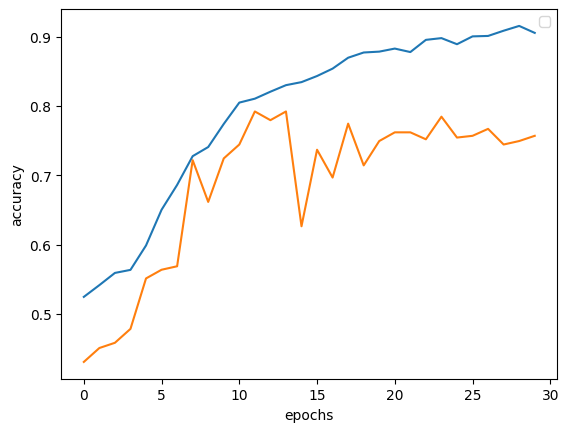

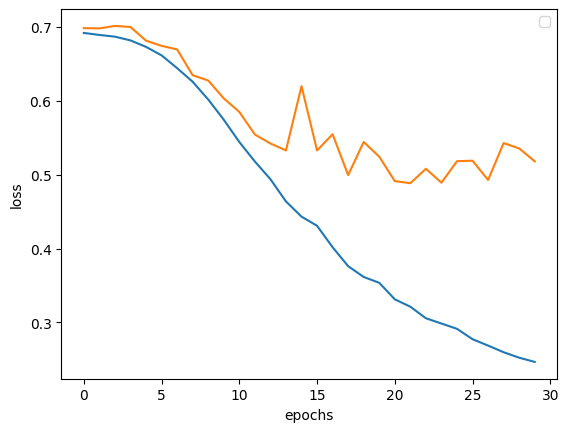

In [17]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel('epochs')
  plt.ylabel(string)
  plt.legend([string], 'val_'+string)
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Define a function to predict the sentiment of reviews
We'll be creating models with some differences and will use each model to predict the sentiment of some new reviews.

To save time, create a function that will take in a model and some new reviews, and print out the sentiment of each reviews.

The higher the sentiment value is to 1, the more positive the review is.

In [18]:
# Define a function to take a series of reviews
# and predict whether each one is a positive or negative review

# max_length = 100 # previously defined

def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True ):
  # Keep the original sentences so that we can keep using them later
  # Create an array to hold the encoded sequences
  new_sequences = []

  # Convert the new reviews to sequences
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type='post'
  padding_type='post'

  # Pad all sequences for the new reviews
  new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length,
                                 padding=padding_type, truncating=trunc_type)

  classes = model.predict(new_reviews_padded)

  # The closer the class is to 1, the more positive the review is
  for x in range(len(new_sentences)):

    # We can see the padded sequence if desired
    # Print the sequence
    if (show_padded_sequence):
      print(new_reviews_padded[x])
    # Print the review as text
    print(new_sentences[x])
    # Print its predicted class
    print(classes[x])
    print("\n")

In [19]:
# Use the model to predict some reviews
fake_reviews = ["I love this phone",
                "Everything was cold",
                "Everything was hot exactly as I wanted",
                "Everything was green",
                "the host seated us immediately",
                "they gave us free chocolate cake",
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

predict_review(model, fake_reviews)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.8561763]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.24002625]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.32974687]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.

Define a function to train and show the results of models with different layers
In the rest of this colab, we will define models, and then see the results.

Define a function that will take the model, compile it, train it, graph the accuracy and loss, and then predict some results.

In [20]:
def fit_model_now (model, sentences) :
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  history = model.fit(training_sequences, training_labels_final, epochs=num_epochs,
                      validation_data=(testing_sequences, testing_labels_final))
  return history

def plot_results (history):
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")

def fit_model_and_show_results (model, sentences):
  history = fit_model_now(model, sentences)
  plot_results(history)
  predict_review(model, sentences)

Add a bidirectional LSTM
Create a new model that uses a bidirectional LSTM.

Then use the function we have already defined to compile the model, train it, graph the accuracy and loss, then predict some results.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5624 - loss: 0.6891 - val_accuracy: 0.4486 - val_loss: 0.7173
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6337 - loss: 0.6573 - val_accuracy: 0.6416 - val_loss: 0.6242
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7773 - loss: 0.5014 - val_accuracy: 0.6967 - val_loss: 0.5647
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8609 - loss: 0.3392 - val_accuracy: 0.7820 - val_loss: 0.5048
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9107 - loss: 0.2592 - val_accuracy: 0.7719 - val_loss: 0.5369
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9388 - loss: 0.2013 - val_accuracy: 0.7594 - val_loss: 0.6208
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9498 - loss: 0.1654 - val_accuracy: 0.7594 - val_loss: 0.6547
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9565 - loss: 0.1458 - val_accuracy: 0.7644 - v

<ipython-input-17-3121198271>:8: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend([string], 'val_'+string)


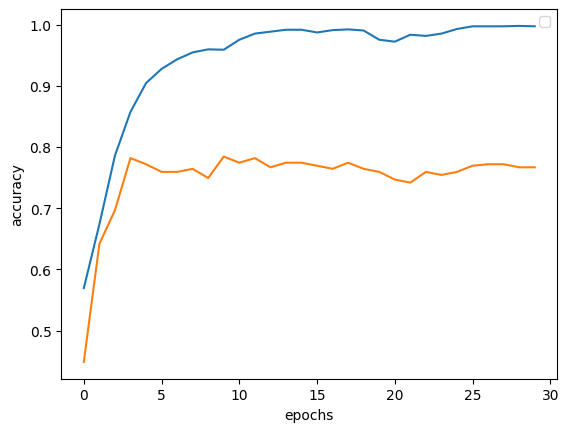

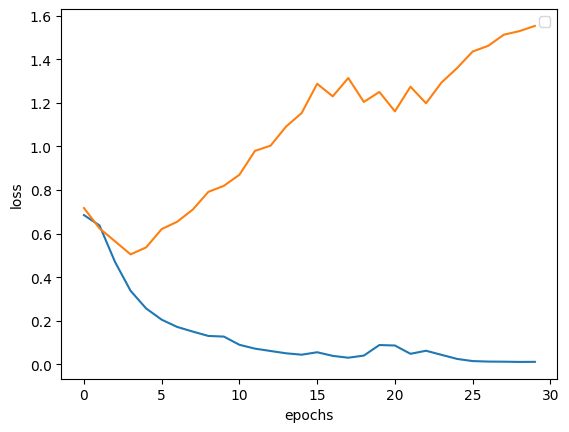

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9989693]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.00134255]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.06687079]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.

In [21]:
# Define the model
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(model_bidi_lstm, fake_reviews)


Use multiple bidirectional layers
Now let's see if we get any improvements from adding another Bidirectional LSTM layer to the model.

Notice that the first Bidirectionl LSTM layer returns a sequence.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5061 - loss: 0.6923 - val_accuracy: 0.4411 - val_loss: 0.6967
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6102 - loss: 0.6650 - val_accuracy: 0.5915 - val_loss: 0.7249
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8065 - loss: 0.4583 - val_accuracy: 0.7419 - val_loss: 0.5391
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8581 - loss: 0.3437 - val_accuracy: 0.7469 - val_loss: 0.6063
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9180 - loss: 0.2388 - val_accuracy: 0.7569 - val_loss: 0.5672
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9352 - loss: 0.2035 - val_accuracy: 0.7444 - val_loss: 0.7193
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9614 - loss: 0.1393 - val_accuracy: 0.7544 - val_loss: 0.6675
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9695 - loss: 0.1404 - val_accuracy: 0.7594 - v

<ipython-input-17-3121198271>:8: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend([string], 'val_'+string)


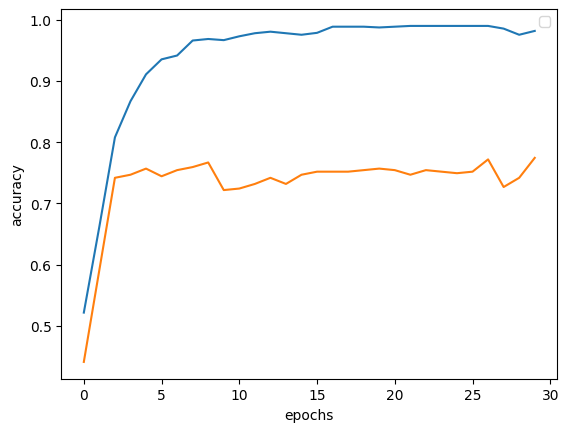

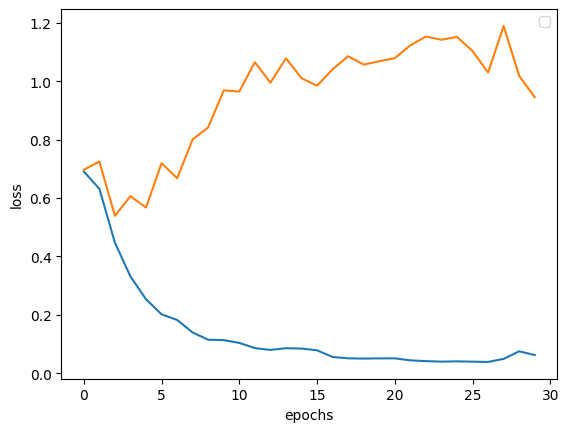

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9962189]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.00998648]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.03644162]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.

In [22]:
model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_model_and_show_results(model_multiple_bidi_lstm, fake_reviews)

:Compare predictions for all the models
It can be hard to see which model gives a better prediction for different reviews when you examine each model separately. So for comparison purposes, here we define some more reviews and print out the predictions that each of the three models gives for each review:

Embeddings and a Global Average Pooling layer
Embeddings and a Bidirectional LSTM layer
Embeddings and two Bidirectional LSTM layers
The results are not always what you might expect. The input dataset is fairly small, it has less than 2000 reviews. Some of the reviews are fairly short, and some of the short ones are fairly repetitive which reduces their impact on improving the model, such as these two reviews:

Bad Quality.
Low Quality.

In [23]:
my_reviews =["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             ]

In [24]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model, my_reviews, show_padded_sequence=False)

 Embeddings only:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
lovely
[0.8684915]


dreadful
[0.48001057]


stay away
[0.6832576]


everything was hot exactly as I wanted
[0.6281234]


everything was not exactly as I wanted
[0.40010646]


they gave us free chocolate cake
[0.7106519]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.05842445]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.5084733]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.78228533]


that place does not have quality meals and it isn't a good place to go for dinner
[0.7220318]




In [25]:
print("===================================\n", "With a single bidirectional LSTM:\n", "===================================")
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence=False)

 With a single bidirectional LSTM:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
lovely
[0.99203366]


dreadful
[0.00740469]


stay away
[0.50874996]


everything was hot exactly as I wanted
[0.62417]


everything was not exactly as I wanted
[0.00361508]


they gave us free chocolate cake
[0.9992273]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.2511649]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.03551041]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.99974567]


that place does not have quality meals and it isn't a good place to go for dinner
[0.9984591]




In [26]:
print("===================================\n","With two bidirectional LSTMs:\n", "===================================")
predict_review(model_multiple_bidi_lstm, my_reviews, show_padded_sequence=False)

 With two bidirectional LSTMs:


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
lovely
[0.99591154]


dreadful
[0.2934817]


stay away
[0.02886855]


everything was hot exactly as I wanted
[0.94330704]


everything was not exactly as I wanted
[0.00978356]


they gave us free chocolate cake
[0.9103473]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.0116283]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.01397673]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.01780829]


that place does not have quality meals and it isn't a good place to go for dinner
[0.00878865]


